In [3]:
import xarray as xr
import numpy as np
import os
from metpy import calc as mpcalc

In [9]:
if os.path.basename(os.path.expanduser("~")) == 'bfildier':
    inputdir = '/Users/bfildier/Data/EUREC4A/merged/sondes'
    sonde_path = os.path.join(inputdir,'all_radiosondes.nc')
    sondes = xr.open_dataset(sonde_path)
else:    
    inputdir = "/run/media/ludo/DATA/google-drive/Thèse/EUREC4a/github/Input/"
    sonde_path = os.path.join(inputdir, "all_sondes.nc")
    sondes = xr.open_dataset(sonde_path)


In [10]:
T_0 = 273.15           # K
R_d = 287.04           # J/kg/K
R_v = 461.4            # J/kg/K
g_to_kg = 0.001

## Saturation vapor pressure from Buck (1981)
def saturationVaporPressure(temp):

    """Argument: Temperature (K) as a numpy.ndarray or dask.array
    Returns: saturation vapor pressure (Pa) in the same format."""

    whereAreNans = np.isnan(temp)
    temp_wo_Nans = temp.copy()
    temp_wo_Nans[whereAreNans] = 0.
    # Initialize
    e_sat = np.zeros(temp.shape)
    e_sat[whereAreNans] = np.nan
    #!!! T > 0C
    overliquid = (temp_wo_Nans > T_0)
    ## Buck
    e_sat_overliquid = 611.21*np.exp(np.multiply(18.678-(temp-T_0)/234.5,
                                                  np.divide((temp-T_0),257.14+(temp-T_0))))
    e_sat[overliquid] = e_sat_overliquid[overliquid]
    #!!! T < 0C 
    overice = (temp_wo_Nans < T_0)
    ## Buck
    e_sat_overice = 611.15*np.exp(np.multiply(23.036-(temp-T_0)/333.7,
                                               np.divide((temp-T_0),279.82+(temp-T_0))))
    e_sat[overice] = e_sat_overice[overice]

    return e_sat       # in Pa

## Compute the saturation specific humidity based on the expressions by Buck
def saturationSpecificHumidity(temp,pres):

    """Convert from estimate of saturation vapor pressure to saturation specific
    humidity using the approximate equation qvsat ~ epsilon"""

    e_sat = saturationVaporPressure(temp)
    qvstar = (e_sat/R_v)/(pres/R_d)

    return qvstar

/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


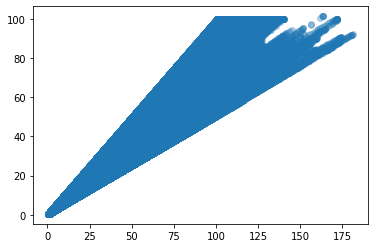

In [11]:
qvstar = saturationSpecificHumidity(sondes.tdry.values+273.15,sondes.pres.values*100)
rh_estimate = sondes.mr.values/qvstar*g_to_kg*100

import matplotlib.pyplot as plt
plt.scatter(rh_estimate,sondes.rh,alpha=0.3)

In [89]:
sondes

<xarray.Dataset>
Dimensions:      (gpsalt: 3000, launch_time: 2586)
Coordinates:
  * gpsalt       (gpsalt) int64 0 10 20 30 40 ... 29950 29960 29970 29980 29990
  * launch_time  (launch_time) datetime64[ns] 2020-01-15T15:19:15 ... 2020-02-16T04:14:33
Data variables:
    time         (launch_time, gpsalt) datetime64[ns] ...
    pres         (launch_time, gpsalt) float64 ...
    tdry         (launch_time, gpsalt) float64 ...
    dp           (launch_time, gpsalt) float64 ...
    rh           (launch_time, gpsalt) float64 ...
    u_wind       (launch_time, gpsalt) float64 ...
    v_wind       (launch_time, gpsalt) float64 ...
    wspd         (launch_time, gpsalt) float64 ...
    wdir         (launch_time, gpsalt) float64 ...
    mr           (launch_time, gpsalt) float64 ...
    theta        (launch_time, gpsalt) float64 ...
    theta_e      (launch_time, gpsalt) float64 ...
    theta_v      (launch_time, gpsalt) float64 ...
    lat          (launch_time, gpsalt) float64 ...
    lon          (launch_time, gpsalt) float64 ...
    ascent_flag  (launch_time) float64 ...

In [90]:
def replace_with_mean(sondes,varid):
    # take mean
    var_mean = sondes.variables[varid].mean(axis=0).values[np.newaxis,:]
    # duplicate
    var_mean_ntimes = np.repeat(var_mean,
              sondes.dims['launch_time'],0)
    # assign in xarray
    return sondes.update({varid:(('launch_time','gpsalt'),var_mean_ntimes)})
    

In [91]:
# First remove variables unused for radiative calculation
# and which could lead to confusion after taking averages
sondes = sondes.drop_vars(["theta","theta_e","theta_v"])

In [102]:
var_mean = sondes.variables[varid]
np.mean(var_mean.values,axis=0)

RuntimeError: NetCDF: HDF error

In [92]:
var2avg = 'Q'
varids = {'T':'tdry','Q':'mr','RH':'rh'}
varid = varids[var2avg]

# Average chosen variable
sondes = replace_with_mean(sondes,varid)

#TODO # if var2avg is temperature or Q, recalculate RH
#TODO # (unnecessary but why not)

#TODO # if var2avg is RH, recalculate Q

RuntimeError: NetCDF: HDF error

In [85]:
# save file
new_filename = 'proxy_sondes_fixed%s.nc'%var2avg
sondes.to_netcdf(os.path.join(inputdir,new_filename))